In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp
import scipy 
import cv2 as cv

from helper.helper_plot import *

plt.rcParams['image.cmap'] = "turbo"

## 4. Generalized Operators for Graph Signals

### 4.1. Filtering Definition

**a. Spectral Filtering**

$$
\hat{f}_{out}(\lambda_l) = \hat{f}_{in}(\lambda_l) \hat{h}(\lambda_l)
$$
$$
\longleftrightarrow
$$
$$
f_{out}(i) = \sum_{l=0}^{N-1} \hat{f}_{in} (\lambda_l) \hat{h}(\lambda_l) u_l(i)
$$

This multiplication property in graph spectral domain results in the following equation:

$$
f_{out} = \hat{h}(Ł) f_{in}
$$
where 
$$
\hat{h}(Ł) = U \begin{bmatrix}
\hat{h}(\lambda_0) & ... & 0 \\
... & ... & ... \\
0 & ... & \hat{h}(\lambda_{N-1})
\end{bmatrix} U^T
$$

### 4.2. Denoising by Filtering

The basic graph spectral filtering can be used to implement discrete versions of well-known continuous filtering techniques. In particular, many of these filters arise as solutions to variational problems to regularize ill-posed inverse problems such as denoising, inpainting and super-resolution. One example is the discrete regularization framework

$$
    \min_{\textbf{f}} \{ ||\textbf{f}-\textbf{y}||_2^2 + \gamma S_p(\textbf{f})\}
$$

**Denoising Example - Tikhonov Regularization:**

We observe a noisy graph signal $\textbf{y}=\textbf{f}_0+\eta$, where $\eta$ is uncorrelated additive Gaussian noise and we wish to recover $\textbf{f}_0$. To enforce a priori information that $\textbf{f}_0$ is smooth, we include a regularization form $\textbf{f}^T Ł \textbf{f}$:

$$
    \min_{\textbf{f}} \{ ||\textbf{f}-\textbf{y}||_2^2 + \gamma \textbf{f}^T Ł \textbf{f}\}
$$

The first-order optimality conditions of the convex objective function show that the optimal reconstruction is given by
$$
f_* (i) = \sum^{N-1}_{l=0} \begin{bmatrix} \frac{1}{1 + \gamma \lambda_l} \end{bmatrix} \hat{y}(\lambda_l) u_l(i)
$$
or, equivalently, $\textbf{f} = \hat{h}(Ł) \textbf{y}$, where $\hat{h}(\lambda) = \frac{1}{1+ \gamma \lambda}$ can be viewed as a low-pass filter.

**Pf:**

The objective function in the minimization problem is convex. Therefore, the problem can be solved by the first-order optimality condition, which is
* Take the derivative of the objective function
* Make equal to zero and solve the equation

Then, the following equation is obtained:

$$
\textbf{f} - \textbf{y} + \gamma Ł \textbf{f} = 0
$$

Use the fact that $Ł = U \Lambda U^T$, then we have the following: 
$$
\gamma  U \Lambda U^T \textbf{f} = \textbf{y} - \textbf{f}
$$

Take the graph Fourier transform of both sides of the equation, i.e. multiply by $U^T$,
$$
\gamma \Lambda U^T \textbf{f} = \hat{\textbf{y}} - \hat{\textbf{f}}
$$

This equation can be written in graph Fourier domain:
$$
\gamma \Lambda \hat{\textbf{f}} = \hat{\textbf{y}} - \hat{\textbf{f}}
$$

$$
\hat{\textbf{f}} + \gamma \Lambda \hat{\textbf{f}} = \hat{\textbf{y}}
$$

This can also be written as:

$$
\hat{\textbf{f}}(\lambda_l) + \gamma \lambda_l \hat{\textbf{f}}(\lambda_l) = \hat{\textbf{y}}(\lambda_l)
$$

$$
\hat{\textbf{f}}(\lambda_l) = \frac{1}{1 + \gamma \lambda_l} \hat{\textbf{y}}(\lambda_l)
$$
End of proof $\square$


* **Whole method:**

The experiment is done ony 512x512 cameraman image and corrupt it with additive Gaussian noise with mean zero, 0.1 std to get a noisy signal. 
Form a semi-local graph on the pixels by connecting each pixel to its horizontal, vertical and diagonal neighbors and setting the Gaussian weights edges of the semi-local graph are independent of the noisy image, but the distances are the differences between the neighboring pixel values in the noisy image. Take $\theta = 0.1$ and $\mathcal{K}=0$ for Gaussian graph construction. Then perform low-pass graph filtering with $\gamma = 10$ to reconstruct the image. 

In [21]:
class OurLPF(pygsp.filters.Filter):

    def __init__(self, G, scale=10, normalize=False):

        try:
            iter(scale)
        except TypeError:
            scale = [scale]

        self.scale = scale
        self.normalize = normalize

        def kernel(x, scale):
            return np.minimum(1/(1+ scale * x), 1)

        kernels = []
        for s in scale:
            norm = np.linalg.norm(kernel(G.e, s)) if normalize else 1
            kernels.append(lambda x, s=s, norm=norm: kernel(x, s) / norm)

        super(OurLPF, self).__init__(G, kernels)

    def _get_extra_repr(self):
        scale = '[' + ', '.join('{:.2f}'.format(s) for s in self.scale) + ']'
        return dict(scale=scale, normalize=self.normalize)

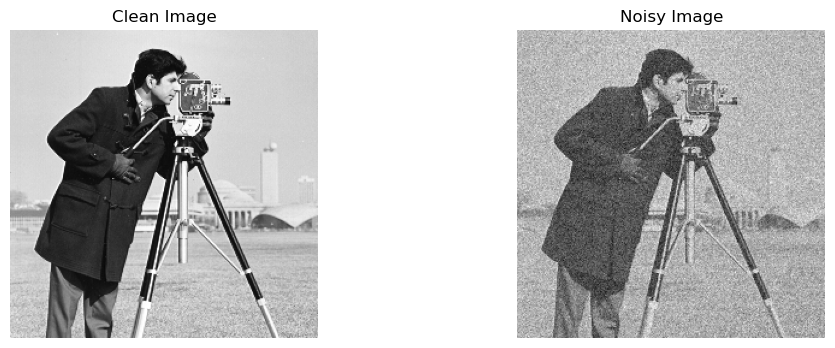

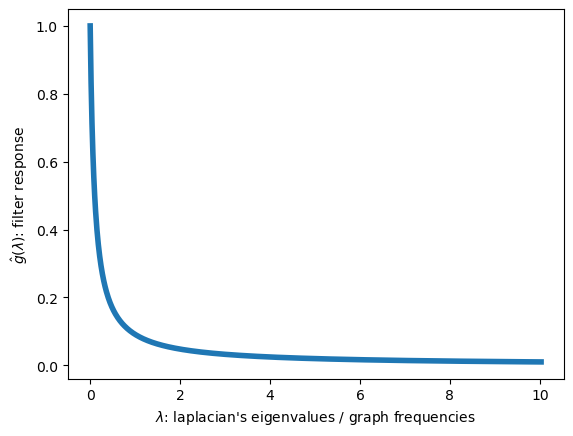

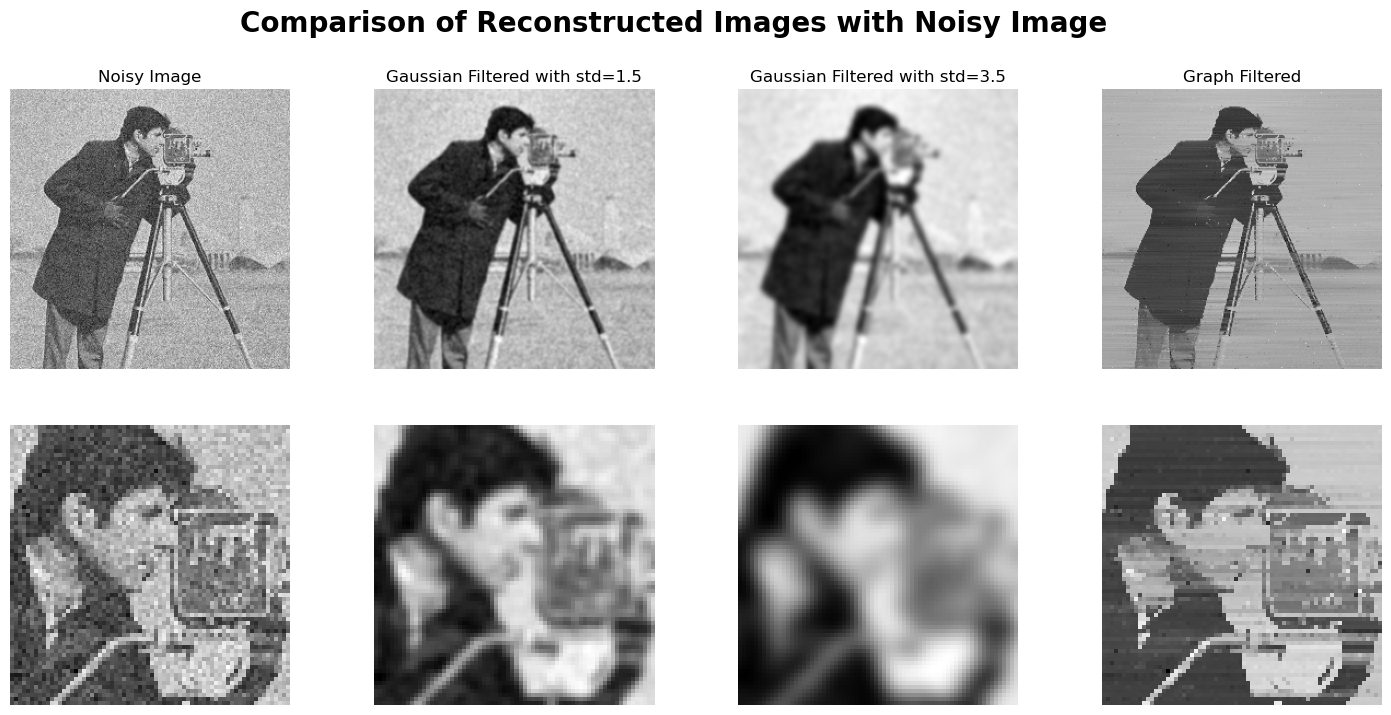

In [22]:
f = plt.imread("imgs/cman.tif") / 255.0

rs = np.random.RandomState(5)
n = rs.randn(f.shape[0], f.shape[1])*0.1
y = f + n

fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].imshow(f, cmap="gray")
axes[1].imshow(y, cmap="gray")
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[0].set_title("Clean Image")
axes[1].set_title("Noisy Image")
plt.show()

Theta = 0.1
K = 1e-5

Nx, Ny = y.shape

rows = np.concatenate([
    np.arange(Nx*Ny-1),
    np.arange(Nx*Ny-4), 
    np.arange(Nx*Ny-5), 
    np.arange(Nx*Ny-6)
])
cols = rows + np.concatenate([
    np.ones(Nx*Ny-1),
    4*np.ones(Nx*Ny-4),
    5*np.ones(Nx*Ny-5),
    6*np.ones(Nx*Ny-6)
]).astype(int)

y_1d = y.flatten()
dists = np.abs(y_1d[rows]-y_1d[cols])
data = np.exp(-(dists**2)/(2*(Theta**2)))*(dists>K)

W_csr = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(Nx*Ny,Nx*Ny))
W_csr = W_csr.T + W_csr

c = np.arange(Ny)*Ny
r = c+Nx-1

rs = np.concatenate([
    r, 
    r[:-1], 
    r[:-2]
])
cs = np.concatenate([
    c,                  
    c[1:],  
    c[2:]
])
rs_final = np.concatenate([rs, cs])
cs_final = np.concatenate([cs, rs])

W_lil = W_csr.tolil()
W_lil[rs_final, cs_final] = 0


G = pygsp.graphs.Graph(W_lil)
G.estimate_lmax()

"""
# Plot Graph Signal as 2D Grid Graph
xv, yv = np.meshgrid(np.arange(Nx), np.arange(Ny))
coords = np.stack([xv.flatten(), yv.flatten()], axis=1)
myGraphPlot(G, 
            coords = coords,
            title = "Graph")
"""

Lambda = 10


g = OurLPF(G, scale=Lambda)
g.plot()
s = g.filter(y.flatten(), method="chebyshev")

f_reconst = np.reshape(s, (Nx,Ny))

f_gaus1 = cv.GaussianBlur(y, (75,75), sigmaX=1.5/np.sqrt(2), sigmaY=1.5/np.sqrt(2))
f_gaus2 = cv.GaussianBlur(y, (75,75), sigmaX=3.5/np.sqrt(2), sigmaY=3.5/np.sqrt(2))

fig, axes = plt.subplots(2,4,figsize=(18,8))
axes[0,0].set_title("Noisy Image")
axes[0,0].imshow(y, cmap="gray")
axes[0,0].set_axis_off()
axes[1,0].imshow(y[20:90,100:170], cmap="gray")
axes[1,0].set_axis_off()
axes[0,1].set_title("Gaussian Filtered with std=1.5")
axes[0,1].imshow(f_gaus1, cmap="gray")
axes[0,1].set_axis_off()
axes[1,1].imshow(f_gaus1[20:90,100:170], cmap="gray")
axes[1,1].set_axis_off()
axes[0,2].set_title("Gaussian Filtered with std=3.5")
axes[0,2].imshow(f_gaus2, cmap="gray")
axes[0,2].set_axis_off()
axes[1,2].imshow(f_gaus2[20:90,100:170], cmap="gray")
axes[1,2].set_axis_off()
axes[0,3].set_title("Graph Filtered")
axes[0,3].imshow(f_reconst, cmap="gray")
axes[0,3].set_axis_off()
axes[1,3].imshow(f_reconst[20:90,100:170], cmap="gray")
axes[1,3].set_axis_off()

fig.suptitle('Comparison of Reconstructed Images with Noisy Image\n', fontsize=20, fontweight=700) # or plt.suptitle('Main title')
plt.show()

### 4.3. Convolution

To define a generalized convolution in the graph setting, we can replace the complex exponential in classical signal processing with graph Laplacian eigenvectors:

$$
f_{out}(i) = (f \ast h)(i) = \sum_{l=0}^{N-1} \hat{f}(\lambda_l) \hat{h}(\lambda_l) u_l(i)
$$
which enforces the property that convolution in the vertex domain is equivalent to multiplication in the graph spectral domain.

### 4.4. Translation, Modulation, Dilation

**Translation:**

$$
(T_n g)(i) = \sqrt{N} (g \ast \delta_n)(i) = \sqrt{N} \sum_{l=0}^{N-1} \hat{g}(\lambda_l) u_l^*(n) u_l(i)
$$

* The smoothness of $\hat{g}$ controls the localization of $T_n g$ around the center vertex n. In other words, the magnitude of $(T_n g) (i)$ decreases, as the distance between $i$ and $n$ increases.

* **Mean of graph signal:**
$$
\sum_{i=0}^{N-1} g(i) = \sqrt{N} \sum_{i=0}^{N-1} g(i) \frac{1}{\sqrt{N}} = \sqrt{N} \sum_{i=0}^{N-1} g(i) u^*_{0}(i)
$$

where the eigenvector corresponding to eigenvalue $\lambda_0 = 0$, $u_{0}(i) = \frac{1}{\sqrt{N}}$. This property can be shown from the fact the solution of the equation $Ł u_0 = 0$.

This equation can also be written as:

$$
\sum_{i=0}^{N-1} g(i) = \sqrt{N} \hat{g}(0)
$$

Therefore, the mean of the translated graph signal is:

$$
\begin{align}
\sum_{i=0}^{N-1} (T_n g)(i) &= \sqrt{N} \widehat{(T_n g)}(0) \\
&= \sqrt{N} \sqrt{N} \hat{g}(0) u^*_0(n) \\
&= N \frac{1}{\sqrt{N}} \hat{g}(0) \\
&= \sqrt{N} \hat{g}(0) = \sum_{i=0}^{N-1} g(i)
\end{align}
$$
We can conclude that $\sqrt{N}$ constant enables the mean conservation.


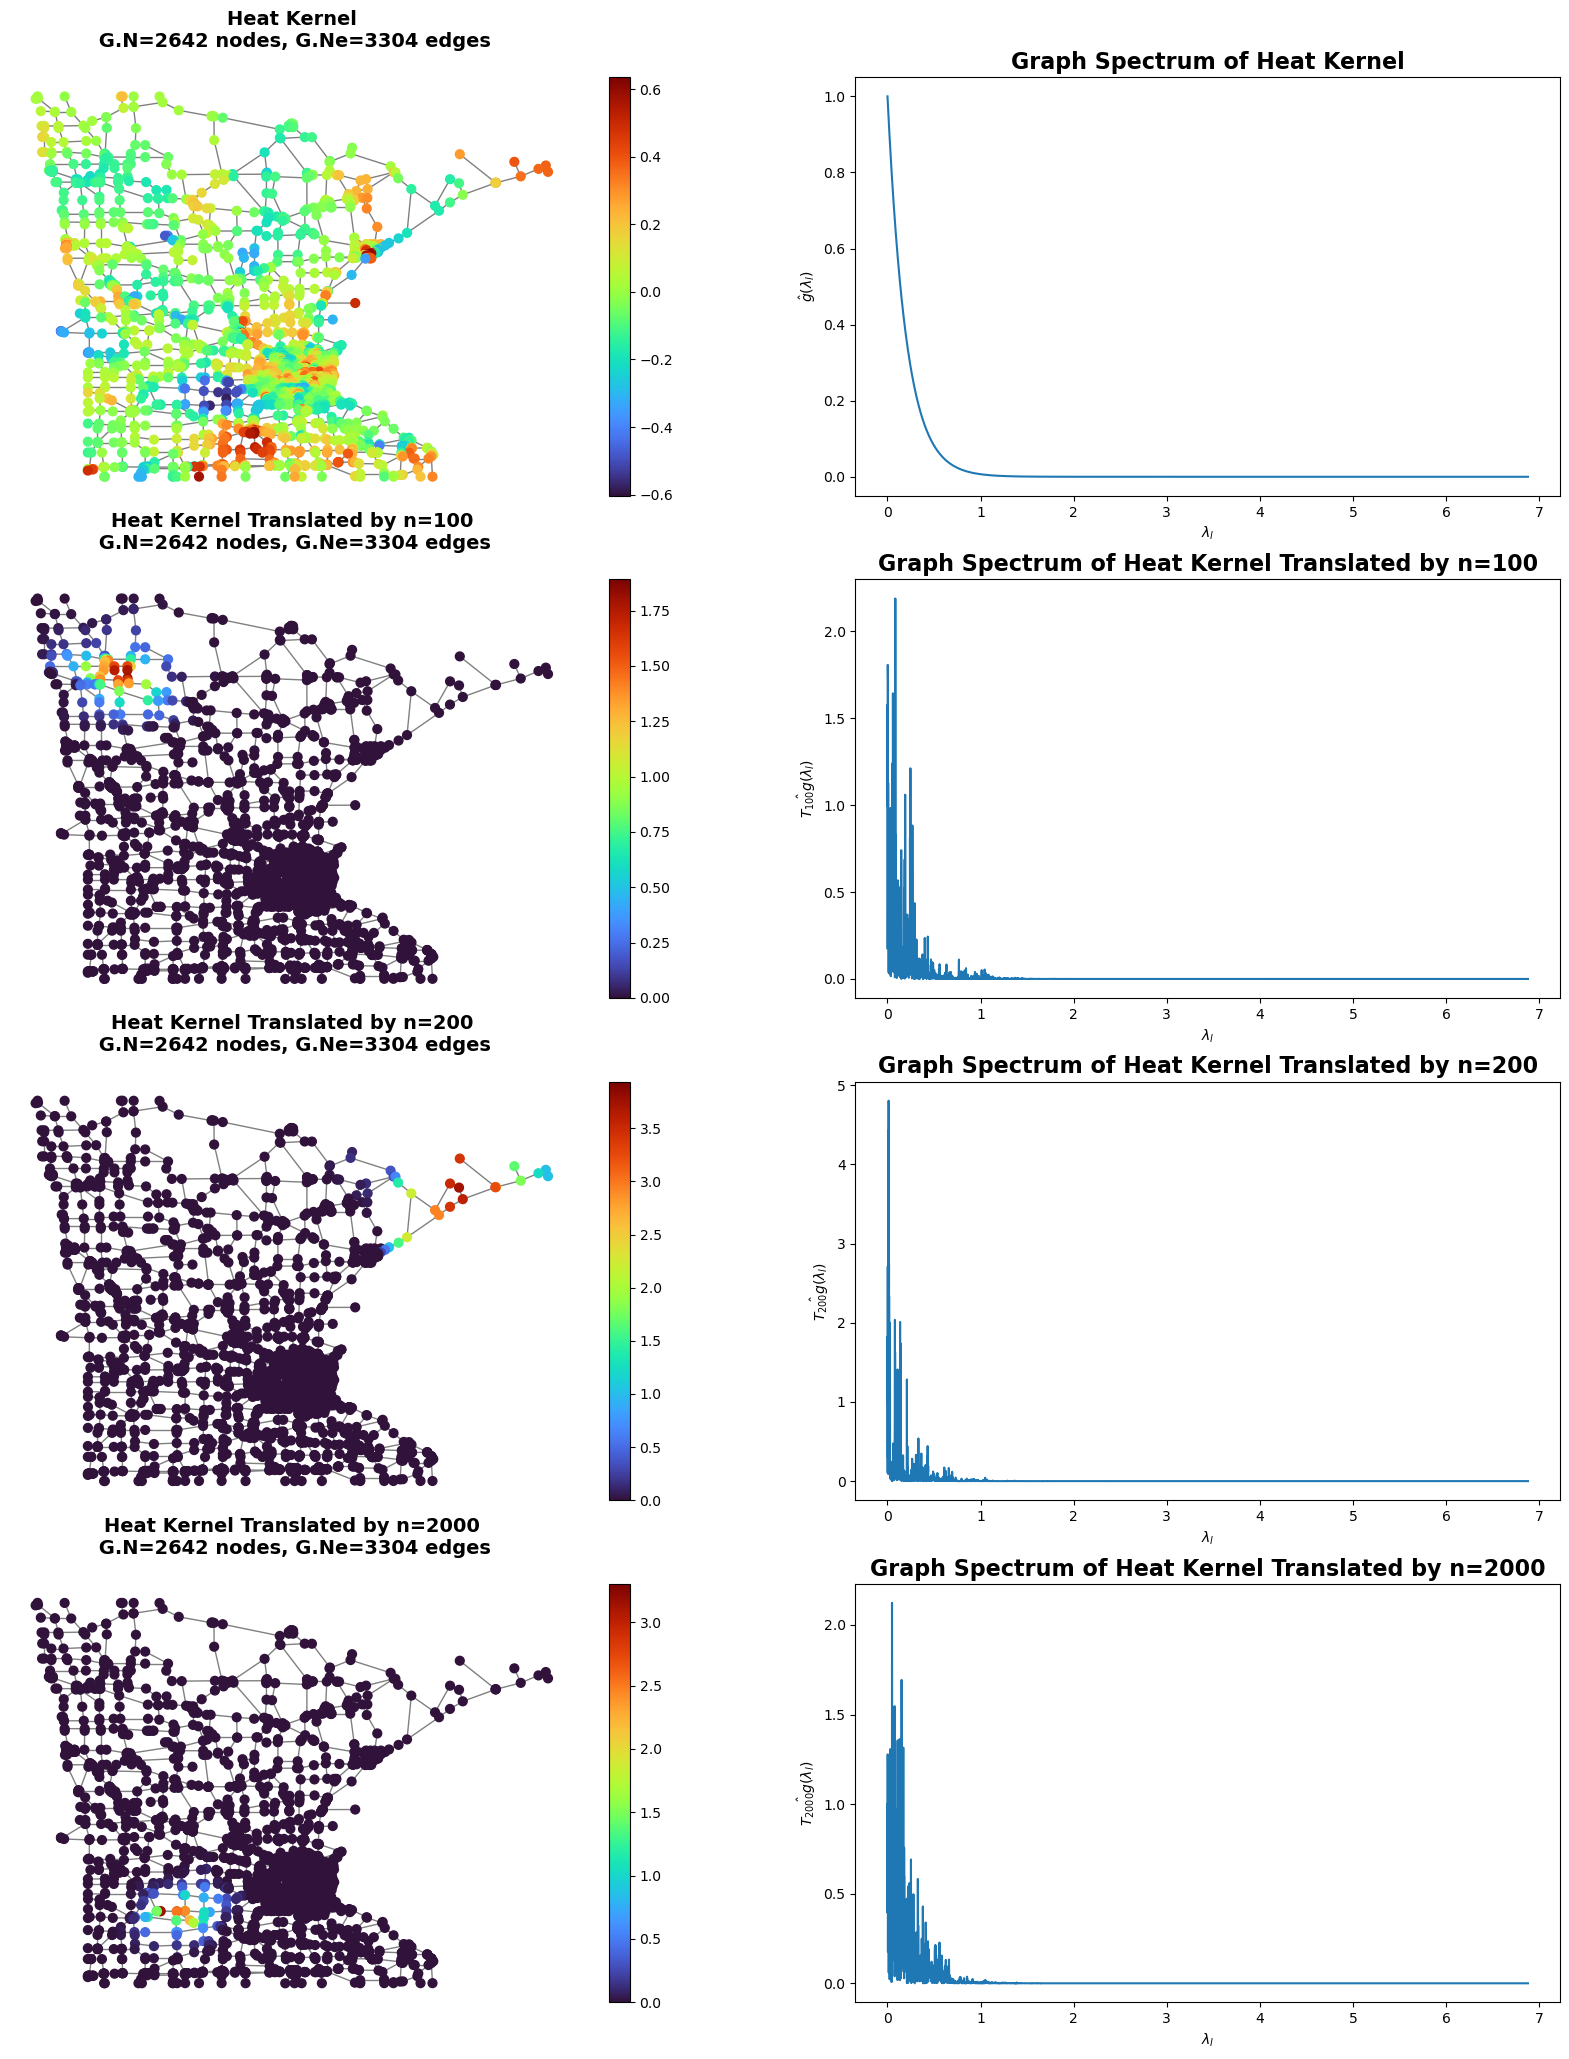

In [23]:
G = pygsp.graphs.Minnesota()
G.compute_laplacian()
G.compute_fourier_basis()

s_hat = np.exp(-5*G.e)

s_hat_100 = s_hat * G.U[99,:] * np.sqrt(G.N)
s_hat_200 = s_hat * G.U[199,:] * np.sqrt(G.N)
s_hat_2000 = s_hat * G.U[1999,:] * np.sqrt(G.N)

s = G.igft(s_hat)
s_100 = G.igft(s_hat_100)
s_200 = G.igft(s_hat_200)
s_2000 = G.igft(s_hat_2000)

fig, axes = plt.subplots(4,2,figsize=(20,25))
myGraphPlotSignal(G, 
            s = s,
            title = "Heat Kernel",
            ax=axes[0,0])
axes[0,1].plot(G.e, s_hat)
axes[0,1].set_title("Graph Spectrum of Heat Kernel", fontsize=16, fontweight=600)
axes[0,1].set_xlabel("$\lambda_l$")
axes[0,1].set_ylabel("$\hat{g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_100,
            title = "Heat Kernel Translated by n=100",
            ax=axes[1,0])
axes[1,1].plot(G.e, np.abs(s_hat_100))
axes[1,1].set_title("Graph Spectrum of Heat Kernel Translated by n=100", fontsize=16, fontweight=600)
axes[1,1].set_xlabel("$\lambda_l$")
axes[1,1].set_ylabel("$\hat{T_{100} g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_200,
            title = "Heat Kernel Translated by n=200",
            ax=axes[2,0])
axes[2,1].plot(G.e, np.abs(s_hat_200))
axes[2,1].set_title("Graph Spectrum of Heat Kernel Translated by n=200", fontsize=16, fontweight=600)
axes[2,1].set_xlabel("$\lambda_l$")
axes[2,1].set_ylabel("$\hat{T_{200} g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_2000,
            title = "Heat Kernel Translated by n=2000",
            ax=axes[3,0])
axes[3,1].plot(G.e, np.abs(s_hat_2000))
axes[3,1].set_title("Graph Spectrum of Heat Kernel Translated by n=2000", fontsize=16, fontweight=600)
axes[3,1].set_xlabel("$\lambda_l$")
axes[3,1].set_ylabel("$\hat{T_{2000} g}(\lambda_l)$")

plt.show()

**Modulation:**

$$
(M_k g)(i) = \sqrt{N}u_k(i)g(i)
$$

* If a kernel $\hat{g}(.)$ is localized around $0$ in graph spectral domain, then $\hat{M_k g}$ is localized around $\lambda_k$.

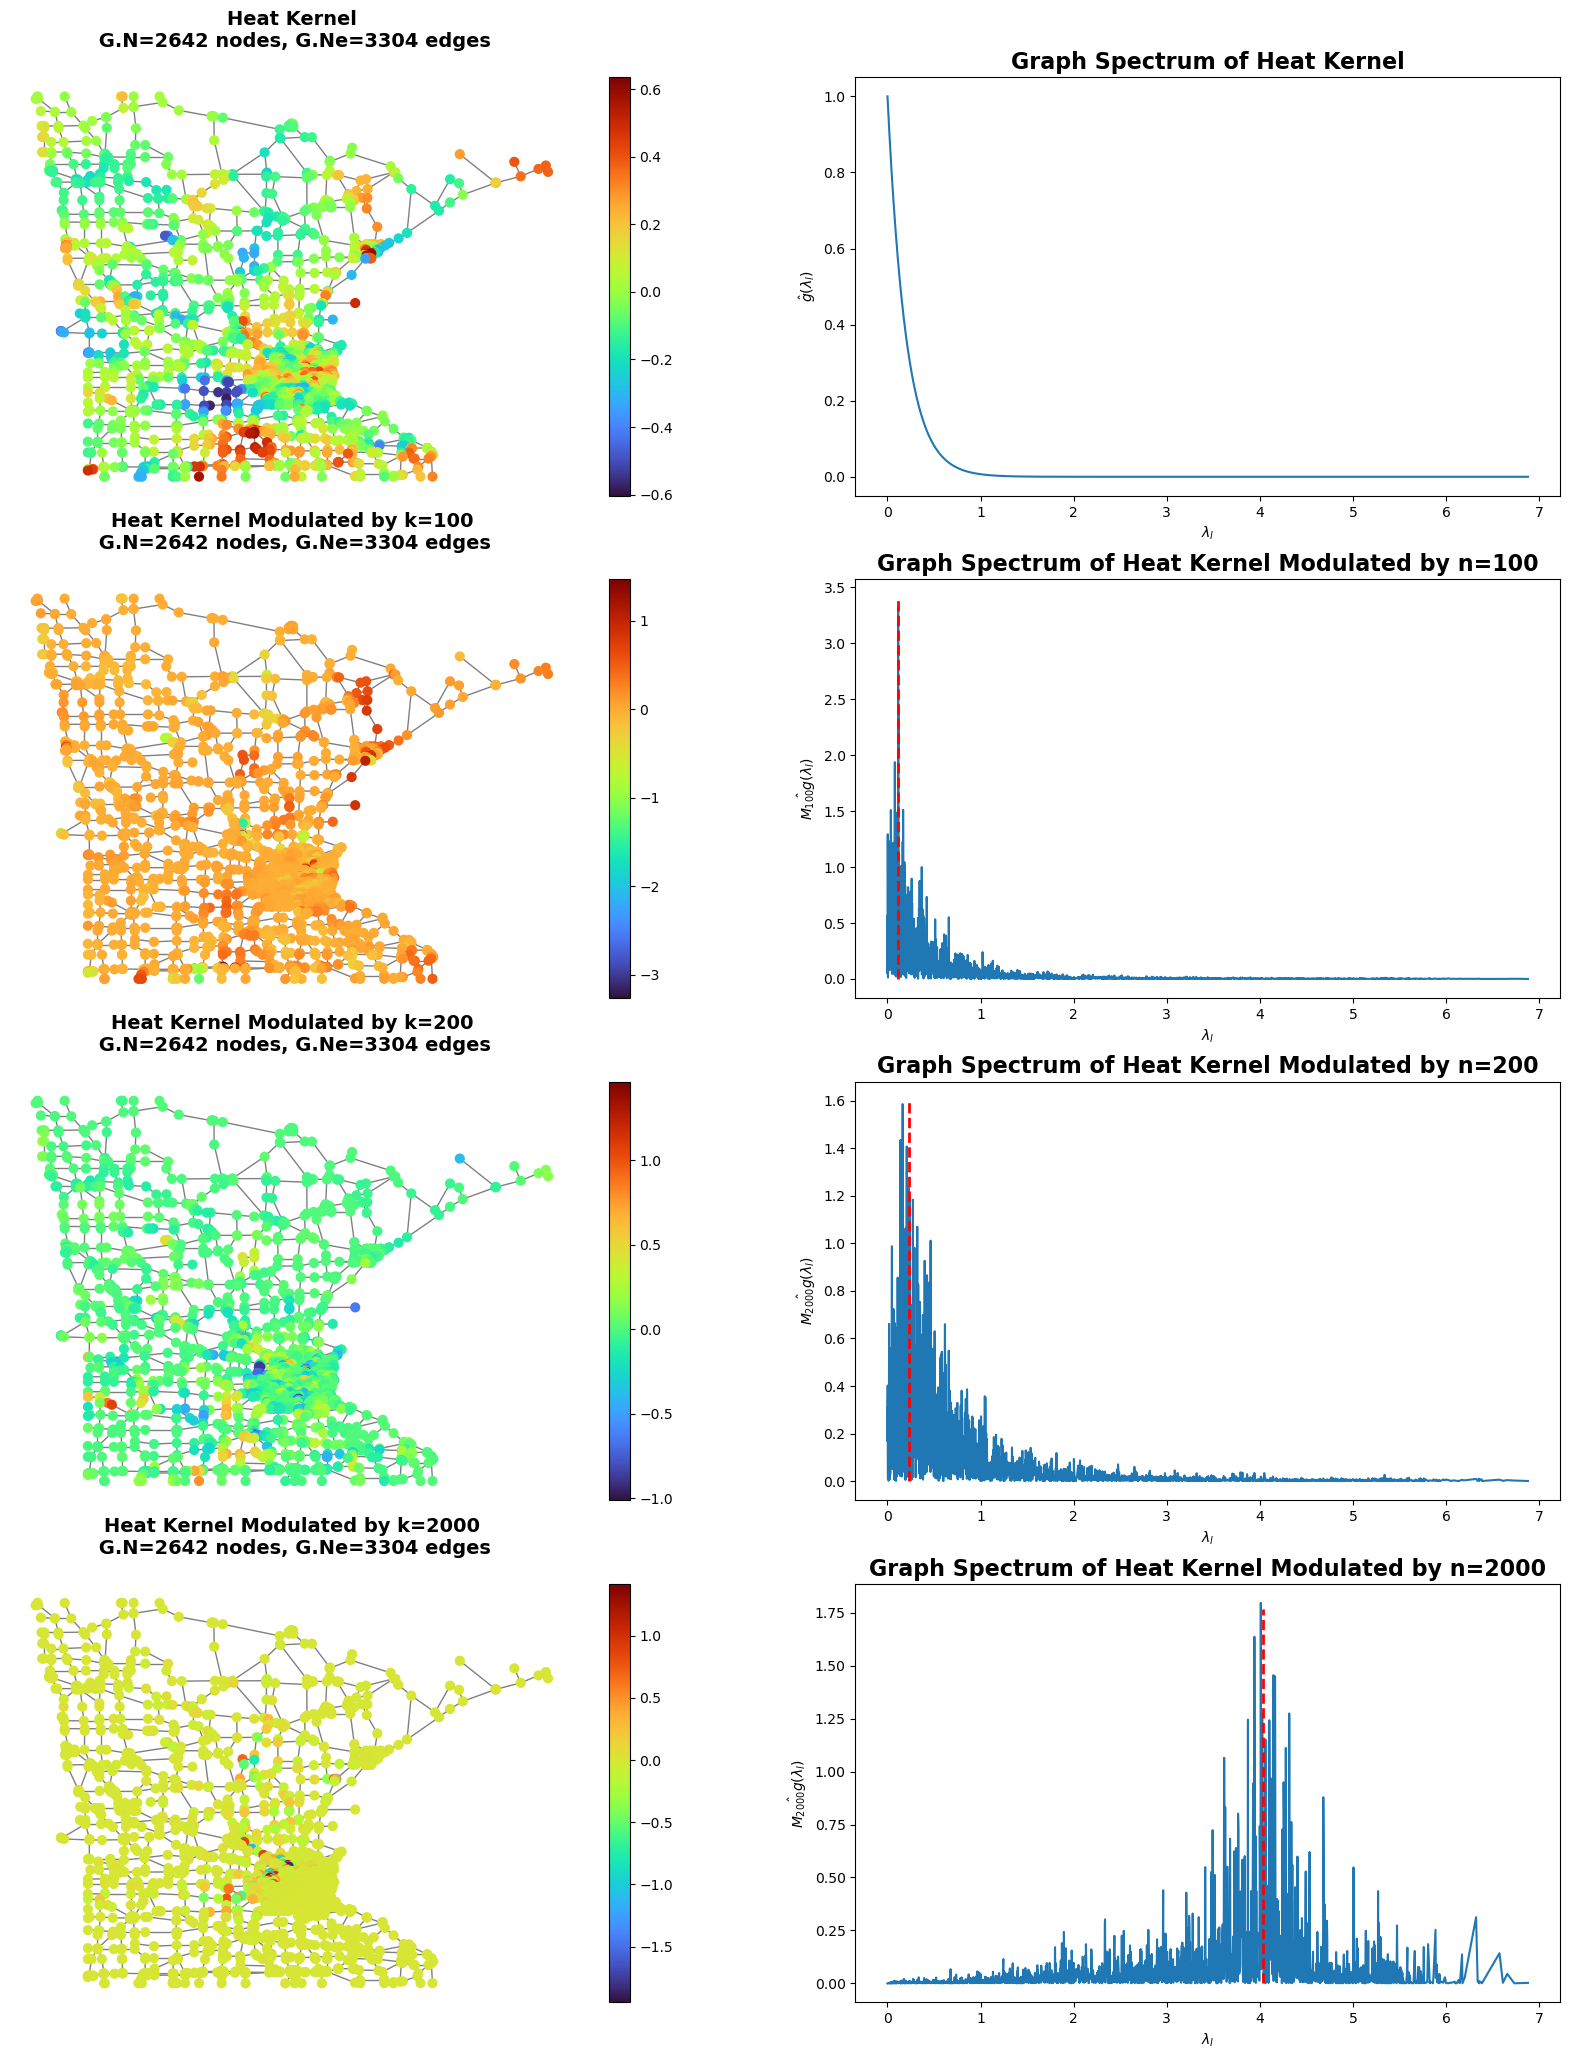

In [24]:
G = pygsp.graphs.Minnesota()
G.compute_laplacian()
G.compute_fourier_basis()

s_hat = np.exp(-5*G.e)
s = G.igft(s_hat)

N = s.shape[0]
s_100 = s * G.U[:,99] * np.sqrt(N)
s_200 = s * G.U[:,199] * np.sqrt(N)
s_2000 = s * G.U[:,1999] * np.sqrt(N)



fig, axes = plt.subplots(4,2,figsize=(20,25))
myGraphPlotSignal(G, 
            s = s,
            title = "Heat Kernel",
            ax=axes[0,0])
axes[0,1].plot(G.e, s_hat)
axes[0,1].set_title("Graph Spectrum of Heat Kernel", fontsize=16, fontweight=600)
axes[0,1].set_xlabel("$\lambda_l$")
axes[0,1].set_ylabel("$\hat{g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_100,
            title = "Heat Kernel Modulated by k=100",
            ax=axes[1,0])
axes[1,1].plot(G.e, np.abs(G.gft(s_100)))
axes[1,1].vlines(G.e[100], 0, 3.4, "r", "dashed", linewidth=2)
axes[1,1].set_title("Graph Spectrum of Heat Kernel Modulated by n=100", fontsize=16, fontweight=600)
axes[1,1].set_xlabel("$\lambda_l$")
axes[1,1].set_ylabel("$\hat{M_{100} g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_200,
            title = "Heat Kernel Modulated by k=200",
            ax=axes[2,0])
axes[2,1].plot(G.e, np.abs(G.gft(s_200)))
axes[2,1].vlines(G.e[200], 0, 1.6, "r", "dashed", linewidth=2)
axes[2,1].set_title("Graph Spectrum of Heat Kernel Modulated by n=200", fontsize=16, fontweight=600)
axes[2,1].set_xlabel("$\lambda_l$")
axes[2,1].set_ylabel("$\hat{M_{2000} g}(\lambda_l)$")

myGraphPlotSignal(G, 
            s = s_2000,
            title = "Heat Kernel Modulated by k=2000",
            ax=axes[3,0])

axes[3,1].plot(G.e, np.abs(G.gft(s_2000)))
axes[3,1].vlines(G.e[2000], 0, 1.77, "r", "dashed", linewidth=2)
axes[3,1].set_title("Graph Spectrum of Heat Kernel Modulated by n=2000", fontsize=16, fontweight=600)
axes[3,1].set_xlabel("$\lambda_l$")
axes[3,1].set_ylabel("$\hat{M_{2000} g}(\lambda_l)$")

plt.show()

**Dilation:**

$$
(\widehat{\mathcal{D}_s g})(\lambda) = \hat{g}(s\lambda) 
$$

Generalized dilation is required to be defined on entire real line, not just on $[0, \lambda_{max}]$.

### 4.5.  Heat Diffusion Operator

Graph heat equation can be defined as follows:

$$
\frac{df}{dt} + L f = 0
$$

where $L$ is graph Laplacian operator.

In graph spectral domain, the equation becomes:

$$
\frac{d \hat{f}}{dt} + \Lambda \hat{f} = 0
$$

This equation is solved in each dimension by th exponential with:

$$
\hat{f} = e^{-t\Lambda} \hat{f}_0
$$

where $\hat{f}_0$ is the initial signal at time $t=0$. As a result, we have:

$$
f(t) = U e^{-t\Lambda} U^T f_0 = U \hat{h}_t(\Lambda)U^T f_0
$$

where $\hat{h}_1(\lambda_l) = e^{-\lambda_l}$ is heat kernel.

In short, heat diffusion operator is:

$$
R^t = e^{-tL} = \widehat{\mathcal{D}_t h}(L)
$$

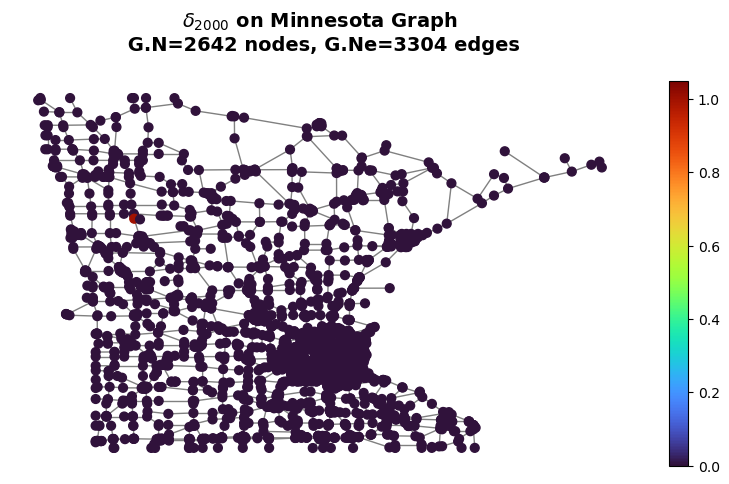

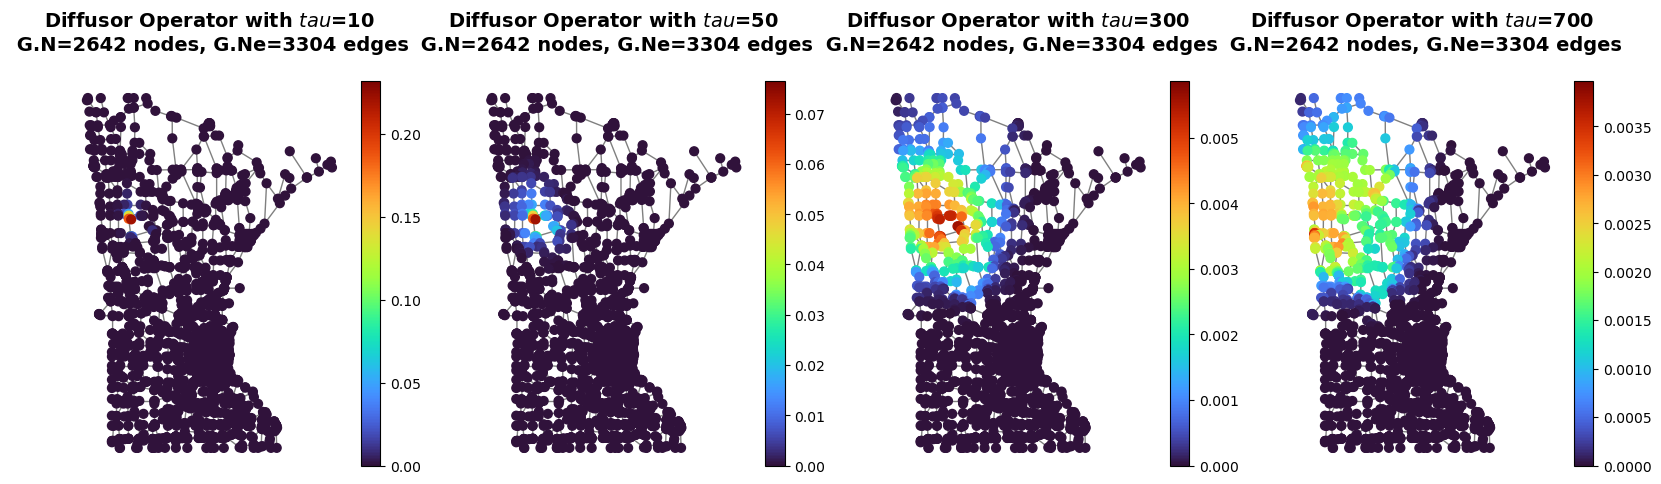

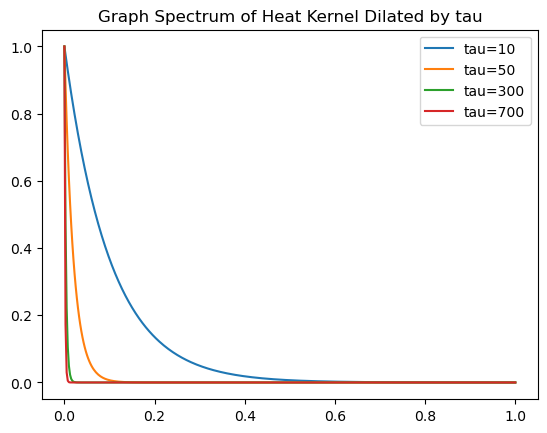

In [26]:
G = pygsp.graphs.Minnesota()
G.compute_laplacian()
G.compute_fourier_basis()

imp = np.zeros(G.N)
imp[320] = 1

myGraphPlotSignal(G, 
            s = imp,
            title = "$\delta_{2000}$ on Minnesota Graph"
)

taus = [10, 50, 300, 700]
g = pygsp.filters.Heat(G, taus)

s = g.filter(imp, method='chebyshev')

fig, axes = plt.subplots(1,len(taus),figsize=(20,5))
for i in range(len(taus)):
    myGraphPlotSignal(G, 
                s = s[:,i],
                title = "Diffusor Operator with $tau$="+str(taus[i]),
                ax=axes[i]
    )
plt.show()

plt.figure()
lambdas = np.linspace(0,1,400)
for i in range(len(taus)):
    plt.plot(lambdas, np.exp(-taus[i]*lambdas), label="tau="+str(taus[i]))
plt.title("Graph Spectrum of Heat Kernel Dilated by tau")
plt.legend()
plt.show()